In [3]:
# Imports
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# For matrix math
import numpy as np
# For normalization + probability density function computation
from scipy import stats
from scipy.stats import multivariate_normal
# For pre-clustering
from sklearn.cluster import KMeans
# Plot style
%matplotlib notebook
# Set plot size in notebook
plt.rcParams["figure.figsize"] = (5, 5)

In [4]:
# Data set
glass = pd.read_csv("../2.Data/Glass_Data.csv")
glass.head(n=5)

,refractive index,sodium oxide,magnesium oxide,aluminum oxide,silicon oxide,potassium oxide,calcium oxide,barium oxide,iron oxide,type
0,1.51761,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [5]:
# Preparing "clean" data

# Values of dataframe
npdata = glass.values
# Separate input data from labels
# 3 Dimensions of input
npinput = npdata[:,1:4]
nplabels = np.delete(npdata,np.s_[:9],1)

# Separate training data (clean)
X_train = np.append(npinput[9:176],npinput[185:], axis=0)
Y_train = np.append(nplabels[9:176],nplabels[185:])
# Rest: Test data (polluted)
X_test = np.append(npinput[:9],npinput[176:185], axis=0)
Y_test = np.append(nplabels[:9],nplabels[176:185])


print(X_train.shape)
print(X_test.shape)


(196, 3)
(18, 3)


In [807]:
# Scale the dataset
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)  

In [808]:
# Define Hyperparameter: Number of PDFs to combine / clusters
classes = 5
# Number of Dimensions:
dimensions = X_train.shape[1]
# Number of (training) instances:
instances = X_train.shape[0]
# Number of test instances:
test_instances = X_test.shape[0]

In [831]:
# K-Clustering to initialize mean vector matrix by pre-clustering
# Only 1 seed with few iterations (heuristic, speed > performance)
kmeans = KMeans(n_clusters=classes, n_init=1, max_iter=100)  
kmeans.fit(X_train) 
mean = kmeans.cluster_centers_
grouping = kmeans.labels_
print(mean.shape)
print(mean)  
print(grouping)  

(5, 3)
[[-0.3803923   0.52436245 -0.11531249]
 [ 1.70235562 -1.46803906  1.05820627]
 [ 0.56667427  0.67061325 -1.05217442]
 [-1.15112262 -1.58465221 -0.05766727]
 [ 0.71605563 -1.66919745  2.80810061]]
[0 0 0 0 0 0 0 0 2 2 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 0 0 0 2 0 0
 0 2 2 2 2 0 0 0 0 0 0 0 2 0 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 2 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 3 3 3 1 3 3 3 3 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 3 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 2 2 0 0 0 0
 2 0 0 0 2 2 4 3 3 3 3 3 3 3 4 4 3 3 3 0 1 0 1 1 1 1 4 1 1 4 4 1 4 1 1 3 1
 1 1 1 1 1 4 4 1 1 1 1]


In [832]:
# Calculate covariance matrices for each of these clusters 
boost = 0.1
cov = np.zeros([dimensions, dimensions, classes])

for i in range(classes):
    
    cluster_i = X_train[np.where(grouping == i)]
    cov_i = np.cov(cluster_i.T)
    # Broadcast and boost to minimize numerical errors later
    cov[:,:,i] = cov_i + np.eye(dimensions)*boost

print(cov.shape)
print(cov)

(3, 3, 5)
[[[ 0.27686646  0.39999395  0.41505113  1.749601    0.57213442]
  [ 0.00354934 -0.09172657  0.01145899 -0.07321523  0.03213017]
  [ 0.02217308  0.02855617 -0.02121458 -0.04219396 -0.13934537]]

 [[ 0.00354934 -0.09172657  0.01145899 -0.07321523  0.03213017]
  [ 0.14297414  0.65742805  0.12139052  0.35600771  0.48500441]
  [-0.00595476 -0.05585133 -0.01862252  0.17695803  0.28945166]]

 [[ 0.02217308  0.02855617 -0.02121458 -0.04219396 -0.13934537]
  [-0.00595476 -0.05585133 -0.01862252  0.17695803  0.28945166]
  [ 0.26782428  0.5720762   0.46812352  0.97816012  0.42431184]]]


In [833]:
# Initialize weight vector
weight = []
for i in range(classes):
    weight = np.append(weight,1/classes)
print(weight)

[0.2 0.2 0.2 0.2 0.2]


In [834]:
# E-Step
# Arguments: number of classes (M), weights (w), pdfs(mu,sigma)
# Returns: responsibilities

def E_step(M,w,mu,sigma):
    
    pvalues = np.zeros([instances, classes])
    rvalues = np.zeros([instances, classes])
    
    for m in range(M):
        pvalues[:,m] = w[m] * multivariate_normal.pdf(X_train, mean=mu[m], cov=sigma[:,:,m])
    for i in range(instances):
        rvalues[i,:] = pvalues[i,:] / np.sum(pvalues[i,:])

    return rvalues

In [835]:
# M-Step
# Arguments: number of classes (M), responsibilities (r), x-values (X)
# Returns: w_new, mu_new, cov_new

def M_step(M,r,X):
    
    ### New weights ###
    w_new = np.sum(r,axis=0) / instances
    
    #### New mean vector ###
    mu_raw = np.matmul(r.T,X)
    # Normalize
    mu_new = np.empty([M,dimensions])
    for m in range(M):
        mu_new[m] = mu_raw[m] / np.sum(r,axis=0)[m]
    
    ### New covariance (Method a (np) or b (low-level)) ###
    cov_new_a = np.zeros([dimensions, dimensions, classes])
    for m in range(classes):
        cov_new_a[:,:,m] = np.cov(X.T, ddof=0, aweights = r[:,m])
    
    cov_new_b = np.zeros([dimensions, dimensions, classes])
    for m in range(classes):
        cov_vect = np.zeros([dimensions, dimensions])
        for i in range(instances):
            cov_vect = cov_vect + r[i,m] * np.outer((X[i]-mu_new[m,:]),
                                                    (X[i]-mu_new[m,:]).T)
        cov_new_b[:,:,m] = cov_vect / np.sum(r,axis=0)[m]
    
    return   w_new, mu_new, cov_new_a, cov_new_b

In [836]:
# EM-Algorithm
iterations = 50

# E-Step 1
results = E_step(classes,weight,mean,cov)
#print(results)

# M-Step 1
w_new, mu_new, cov_new_a, cov_new_b = M_step(classes,results,X_train)

# Iterations:

# Store the progression of weight(2) for example:
w_new_collection = np.empty([iterations])

for i in range(iterations):
    results = E_step(classes,w_new, mu_new, cov_new_b)
    w_new, mu_new, cov_new_a, cov_new_b = M_step(classes,results,X_train)
    w_new_collection[i] = w_new[3]

print(mu_new)
print(cov_new_a)

[[-0.23757325  0.49998905 -0.27616052]
 [ 1.3854101  -1.06405884  0.90641453]
 [-0.1497426   0.61962383 -0.41366046]
 [-0.74857239 -1.51407114 -0.07147869]
 [ 1.19384341 -1.74491199  2.44510052]]
[[[ 2.37591872e-01  3.45930998e-01  4.01448203e-01  2.52114777e+00
    6.72317604e-01]
  [ 3.83496829e-02 -2.46450141e-01  3.25630542e-02  1.22957998e-01
   -4.45398751e-02]
  [-1.77052803e-02  1.11670461e-01 -2.74442756e-01 -8.77526716e-02
   -3.80311367e-01]]

 [[ 3.83496829e-02 -2.46450141e-01  3.25630542e-02  1.22957998e-01
   -4.45398751e-02]
  [ 5.61942016e-02  9.58315602e-01  6.74718964e-03  3.04299591e-01
    2.26873675e-01]
  [-1.42746642e-04 -7.73488677e-02 -3.81087396e-02  1.58300405e-01
    2.10697902e-01]]

 [[-1.77052803e-02  1.11670461e-01 -2.74442756e-01 -8.77526716e-02
   -3.80311367e-01]
  [-1.42746642e-04 -7.73488677e-02 -3.81087396e-02  1.58300405e-01
    2.10697902e-01]
  [ 1.59617951e-01  1.52377221e-01  4.86365019e-01  7.84541099e-01
    4.22242742e-01]]]


<IPython.core.display.Javascript object>


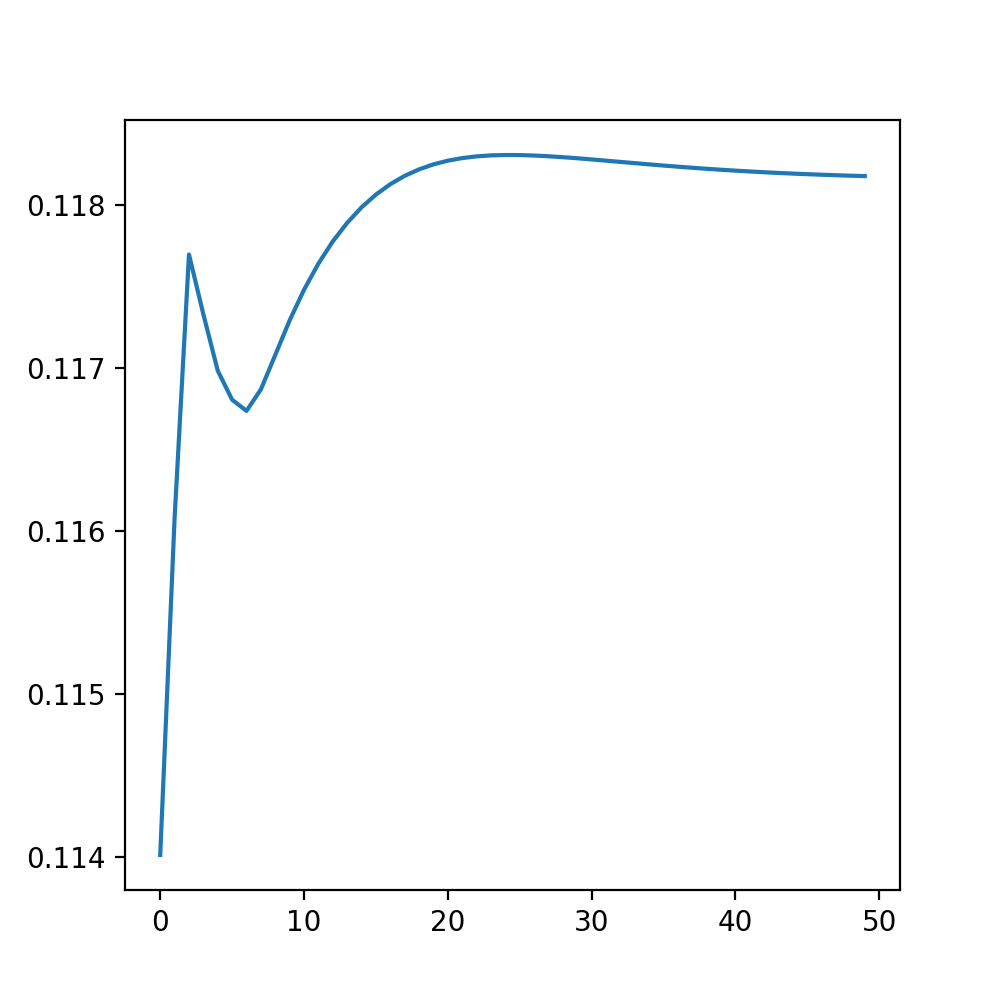

In [837]:
# EM-Algorithm analysis of convergence
sns.lineplot(range(iterations),w_new_collection)
plt.show()

In [838]:
# Identifying the outliers 
cutoff = 0.05
densities = np.zeros([test_instances,classes])
pdfvalues = np.zeros([test_instances])

for m in range(classes):
    densities[:,m] = multivariate_normal.pdf(X_test, mean=mu_new[m], cov=cov_new_a[:,:,m])

# Combining the PDFunctions by multiplying with according weights
pdfvalues = np.matmul(densities,w_new)

In [839]:
# Results, (Confusion matrix (?))
for i in range(test_instances):
    if pdfvalues[i] < cutoff:
        print("Instance ", i, ": Outlier")
    else:
        print("Instance ", i, ": Normal")

Instance  0 : Outlier
Instance  1 : Normal
Instance  2 : Normal
Instance  3 : Normal
Instance  4 : Normal
Instance  5 : Normal
Instance  6 : Normal
Instance  7 : Normal
Instance  8 : Normal
Instance  9 : Outlier
Instance  10 : Outlier
Instance  11 : Outlier
Instance  12 : Outlier
Instance  13 : Outlier
Instance  14 : Outlier
Instance  15 : Outlier
Instance  16 : Outlier
Instance  17 : Outlier


In [1]:
# F1 Score
(2*8)/(2*8+0+1)

0.9411764705882353